### imports

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, accuracy_score, recall_score, confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## Data cleaning

<hr style="border: 2px solid #95e89e">

### I. filtering data to selected observation (top 20%)

#### what happens in these next 2 blocks of codes:

- importing datasets
- limiting the store dataset, `Rossmann_store.csv` to just the top 20% of stores in terms of sales
    - done by: calc avg sales for each store, then take top 20% of stores in terms of sales
- similarly, we wanna limit the other dataset we will use, `Rossmann_train.csv` so that it only gives us details of the top 20% sales stores
    - done by: filtering by the Store IDs based on those present in our t20 store df obtained earlier


<i>use this:</i>

In [8]:
# importing datasets
rossmann_store = pd.read_csv("data\Rossmann_store.csv")
rossmann_sales = pd.read_csv("data\Rossmann_train.csv") # from here on the train dataset will be referred to as the sales dataset

<i>followed by this:</i>

In [9]:
# creating a function to calculate the average sales for a store
def calc_avg_sales(store_id: int)-> float:
    """This function takes a store ID and returns the average sales value for that store."""
    a_store = rossmann_sales.loc[ (rossmann_sales['Store'] == store_id) ]
    avg_sales = a_store['Sales'].mean()
    return avg_sales.round(2)

# calculating and recording the average sales for each store
store_avg_sales = []
for i in range(1,1116):
    store_avg_sales.append(calc_avg_sales(i))

# adding the average sales data for each store into the store dataset
rossmann_store_w_avg = pd.concat([rossmann_store, pd.DataFrame({'AverageSales' : store_avg_sales})], axis=1)

# taking the top 20 percent of stores in terms of sales
rossmann_store_t20 = \
rossmann_store_w_avg.loc[ (rossmann_store_w_avg['AverageSales'] >= rossmann_store_w_avg['AverageSales'].quantile(0.8)) ]

# filtering the sales dataset
rossmann_sales_t20 = rossmann_sales.loc[ rossmann_sales['Store'].isin(rossmann_store_t20['Store']) ]

<hr style="border: 2px solid #73deb0">

### II. merging datasets & imputation of missing values for Promo2-related columns

#### what happens in this next block of code (done with method chaining):
- merged datasets
- convert `Date` dtype to datetime
- to reduce confusion, renamed `PromoInterval` to `Promo2Interval` since it's referring to Promo2

- filled in missing values for `Promo2SinceWeek`, `Promo2SinceYear`, and `Promo2Interval`
    - `Promo2SinceWeek`, `Promo2SinceYear` : replaced NaN with <b>0</b> if `Promo2` == 0
    - `Promo2Interval` : replaced NaN with <b>NA</b> (= Not Applicable) if `Promo2` == 0

- created a new column with category codes: `Promo2IntervalCat`
    - category <b>0</b> is <b>NA</b>
    - category <b>1</b> is <b>Jan,Apr,Jul,Oct</b>
    - category <b>2</b> is <b>Feb,May,Aug,Nov</b>
    - category <b>3</b> is <b>Mar,Jun,Sept,Dec</b>


<i>continue from previous section, now use this:</i>

In [10]:
rossmann = (
    pd.merge(rossmann_store_t20, rossmann_sales_t20, on='Store', how='right')   # merging the filtered datasets
    .assign(Date = lambda df: pd.to_datetime(df['Date']))                       # converting Date dtype from to datetime
    .rename(columns={'PromoInterval':'Promo2Interval'})                           # renaming PromoInterval to Promo2Interval
    .fillna({'Promo2SinceWeek':'0','Promo2SinceYear':'0','Promo2Interval':'NA'})  # filling in some missing values
    
    # creating a new column to categorize Promo2Interval
    .assign(Promo2IntervalCat = lambda df: df['Promo2Interval']
            .astype('category')
           )
    
    # changing categories to categorical codes for the new column
    .assign(Promo2IntervalCat = lambda df: pd.Categorical(df['Promo2IntervalCat'], categories= \
                                                          ['NA','Jan,Apr,Jul,Oct','Feb,May,Aug,Nov','Mar,Jun,Sept,Dec'])
            .codes
           )
    
    .set_index('Date')   # setting the Date as our index
)

In [19]:
rossmann.isna().sum()

Store                            0
StoreType                        0
Assortment                       0
CompetitionDistance              0
CompetitionOpenSinceMonth    57874
CompetitionOpenSinceYear     57874
Promo2                           0
Promo2SinceWeek                  0
Promo2SinceYear                  0
Promo2Interval                   0
AverageSales                     0
DayOfWeek                        0
Sales                            0
Customers                        0
Open                             0
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
Promo2IntervalCat                0
dtype: int64

* We observe missing values only exists in `CompetitionOpenSinceMonth` and `CompetitionOpenSinceYear` columns.

<hr style="border: 2px solid #73deb0">

### III. Imputation for continuous data

#### What happens in this next block of code:
- Note that `pipe` method is used as there are multiple data processing functions to call for readability and clarity of code.<br><br>

- **Preliminary Analysis** 
    - setting up **k-Nearest Neighbours** model to observe test scores for different imputation methods
    - test scores includes `accuracy`, `precision` and `recall`.
    - Investigate the most suitable k value to be used in the KNN model using the `elbow method`
<br>

- **Simple imputation**
    - **Mean** and **Median** imputation is used
    - **Testing scores** are computed
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **KNN imputation**
    - try `KNeighborsRegressor` using normalized data
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Linear Regression Imputation**
    - Plot `heatmap` to investigate correlation between variables
    - Use the `IterativeImputer` to impute missing data between the imputation columns and columns with the highest correlation with imputation columns
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Forest Imputation**
    - Use the combination fo `IterativeImputer` and `RandomForestRegressor` to impute missing values.
    - plot distribution graph for **target** and **feature** variables to observe appropriateness of imputation methods
<br>

- **Imputation Conclusion**
    - Concluding imputation findings.
    - Choose the best way of imputation

<hr>


#### **Preliminary Analysis**

* Setting up **k-Nearest Neighbours model**

In [11]:
def kNN_model(df,feature_columns, target, n):
    Xf = df[feature_columns]
    Yf = df[[target]]
    
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=0)
    kNN = KNeighborsClassifier(n_neighbors=n)
    kNN.fit(X_train, Y_train.values.ravel())  # fit the data to the model
    Y_pred = kNN.predict(X_test)  # Predict the target values from the test feature data

    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='binary' if len(Yf[target].unique()) == 2 else 'weighted')
    rec = recall_score(Y_test, Y_pred, average='binary' if len(Yf[target].unique()) == 2 else 'weighted')
    
    print("\n")
    print(f'Testing scores: accuracy {acc:.3f}, precision {prec:.3f}, recall {rec:.3f}')

* Find the n-neighbors for k-Nearest Neighbours using the elbow method

In [12]:
# keep first (may use later)

def elbow_method_knn(df, feature_columns, target, max_k=40, test_size=0.2, random_state=14):
    # Separate features and target
    Xf = df[feature_columns]
    Yf = df[target]

    # Ensure features and target are aligned
    Xf, Yf = Xf.align(Yf, join='inner', axis=0)
    
    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=test_size, random_state=random_state)
    
    error_rate = []

    # Loop through different k values to find the optimal one
    for i in range(1, max_k):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred_i = knn.predict(X_test)
        # Calculate error rate as the proportion of misclassified samples
        error_rate.append(np.mean(pred_i != Y_test))
    
    # Plotting the Mean Absolute Deviation vs. Number of Neighbors
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, max_k), error_rate, color='blue', linestyle='dashed', marker='o',
             markerfacecolor='red', markersize=10)
    plt.title('Mean Absolute Deviation vs. Number of Neighbors')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Error Rate vs. K Value')
    plt.grid(True)
    plt.show()
    
    # Find the optimal number of neighbors
    k = np.argmin(error_rate) + 1
    return k

#optimal_k = elbow_method_knn(rossmann_mean_impute, feature_columns=['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear'], target='Sales')
#print(f"Optimal number of neighbors for k-NN: {optimal_k}")


[[26  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  1  0]]


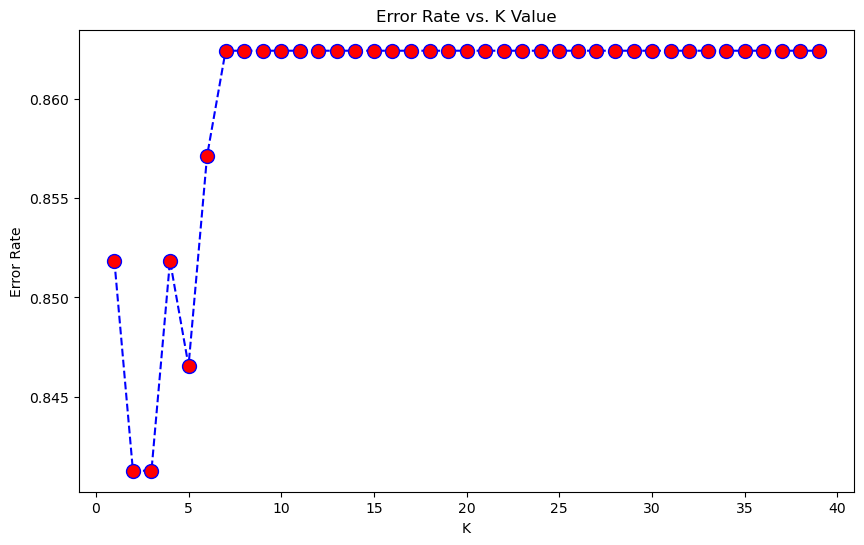

In [22]:
Xf = rossmann[rossmann.select_dtypes(['int','float']).columns.to_list()].dropna().drop_duplicates()
Yf = rossmann['Sales']

Xf = Xf.loc[~Xf.index.duplicated(keep='first')]
Yf = Yf.loc[~Yf.index.duplicated(keep='first')]

# Align Xf and Yf to ensure they have the same indices
Xf, Yf = Xf.align(Yf, join='inner', axis=0)
Xf, Yf = Xf.align(Yf, join='inner', axis=0)


# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(Xf, Yf, test_size=0.2, random_state=13)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,Y_train)
pred = knn.predict(X_test)
print(confusion_matrix(Y_test,pred))


error_rate = []
for i in range(1,40):
    
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,Y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != Y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate');

* As shown in the error rate plot above, the optimal k value will be **k=1**

#### **Simple imputation**

##### Mean Inputation Functions

In [13]:
def impute_mean(df):
    df_mean = df.copy()
    df_mean.fillna(df_mean.mean(),inplace=True)
    return df_mean

    
rossmann_mean_impute = impute_mean(rossmann[rossmann.select_dtypes(['int','float']).columns.to_list()])


Print the testing scores out:

In [14]:
print("Imputation using mean")
kNN_model(rossmann_mean_impute,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)

Imputation using mean


Testing scores: accuracy 0.637, precision 0.680, recall 0.637


##### Median Inputation Functions

In [15]:
def impute_median(df):
    df_median = df.copy()
    df_median.fillna(df_median.median(),inplace=True)
    return df_median


rossmann_median_impute = impute_median(rossmann[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales']])

Print the testing scores out:

In [16]:
print("Imputation using median")
kNN_model(rossmann_median_impute,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)

Imputation using median


Testing scores: accuracy 0.640, precision 0.682, recall 0.640


##### Histogram plot 

* plot histogram to observe the appropriateness of imputation using mean and median

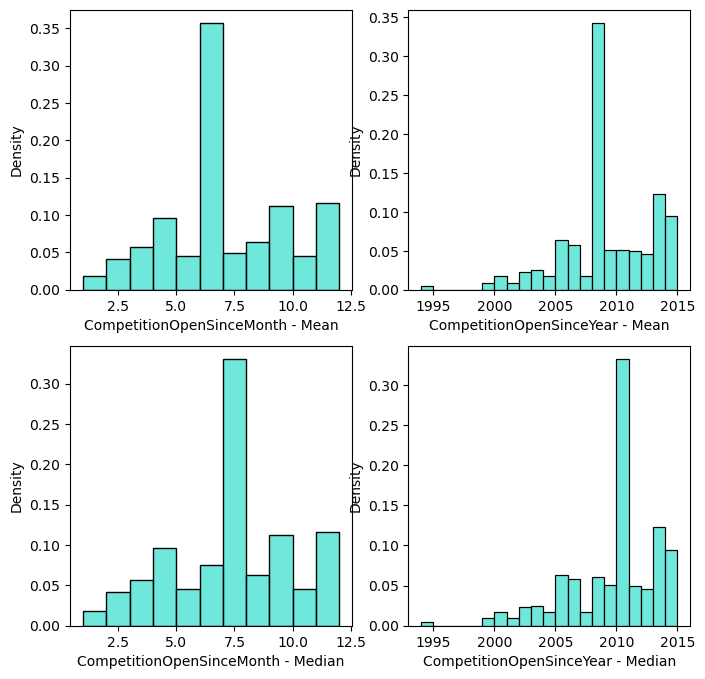

In [17]:
fig, axes = plt.subplots(2,2,figsize=(8, 8))

sns.histplot(rossmann_mean_impute, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0, 0])
axes[0, 0].set_xlabel('CompetitionOpenSinceMonth - Mean')

sns.histplot(rossmann_median_impute, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[1, 0])
axes[1, 0].set_xlabel('CompetitionOpenSinceMonth - Median')

sns.histplot(rossmann_mean_impute, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[0, 1])
axes[0, 1].set_xlabel('CompetitionOpenSinceYear - Mean')

sns.histplot(rossmann_median_impute, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1, 1])
axes[1, 1].set_xlabel('CompetitionOpenSinceYear - Median');

<hr>

**Observations**

- By observing the histogram, we observe a **peak** value which differs a lot with other values for both the **mean and median plot** <br>
- This indicates that mean and median imputation may not be a suitable way to impute the missing data in `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` column.

<hr>

#### **Knn imputation (Using KNeighborsRegressor)**

In [18]:
knn2 = rossmann.select_dtypes(include=['int', 'float']).copy()
filtered_rm = knn2.dropna(subset=['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth'])

# Prepare data for training and testing
X = filtered_rm[['CompetitionDistance','Promo2']]
y_year = filtered_rm['CompetitionOpenSinceYear']
y_month = filtered_rm['CompetitionOpenSinceMonth']


X_train, X_test, y_train_year, y_test_year = train_test_split(X, y_year, test_size=0.2, random_state=1)
X_train, X_test, y_train_month, y_test_month = train_test_split(X, y_month, test_size=0.2, random_state=1)

# Train the k-NN models
knn_m_year = KNeighborsRegressor(n_neighbors=3, weights='distance')
knn_m_month = KNeighborsRegressor(n_neighbors=3, weights='distance')

model_year = knn_m_year.fit(X_train, y_train_year)
model_month = knn_m_month.fit(X_train, y_train_month)

# Find missing values
missing_year = knn2['CompetitionOpenSinceYear'].isnull()
missing_month = knn2['CompetitionOpenSinceMonth'].isnull()

df_missing_year = knn2[['CompetitionDistance','Promo2']][missing_year]
df_missing_month = knn2[['CompetitionDistance','Promo2']][missing_month]

# Predict and impute missing values
year_impute = model_year.predict(df_missing_year)
month_impute = model_month.predict(df_missing_month)

# Create another data set copy to prevent original DataFrame modification
rm_imputed = knn2.copy()

# Impute the predicted values 
rm_imputed.loc[missing_year, 'CompetitionOpenSinceYear'] = year_impute
rm_imputed.loc[missing_month, 'CompetitionOpenSinceMonth'] = month_impute


# Evaluate model
'''
y_pred_test_year = model_year.predict(X_test)
mse_year = mean_squared_error(y_test_year, y_pred_test_year)
r2_year = r2_score(y_test_year, y_pred_test_year)


y_pred_test_month = model_month.predict(X_test)
mse_month = mean_squared_error(y_test_month, y_pred_test_month)
r2_month = r2_score(y_test_month, y_pred_test_month)

print('Year - Mean Squared Error:', mse_year)
print('Year - R^2 Score:', r2_year)
print('Month - Mean Squared Error:', mse_month)
print('Month - R^2 Score:', r2_month)

#rkm_imputed.isna().sum()'''

"\ny_pred_test_year = model_year.predict(X_test)\nmse_year = mean_squared_error(y_test_year, y_pred_test_year)\nr2_year = r2_score(y_test_year, y_pred_test_year)\n\n\ny_pred_test_month = model_month.predict(X_test)\nmse_month = mean_squared_error(y_test_month, y_pred_test_month)\nr2_month = r2_score(y_test_month, y_pred_test_month)\n\nprint('Year - Mean Squared Error:', mse_year)\nprint('Year - R^2 Score:', r2_year)\nprint('Month - Mean Squared Error:', mse_month)\nprint('Month - R^2 Score:', r2_month)\n\n#rkm_imputed.isna().sum()"

In [19]:
kNN_model(rm_imputed,['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.560, precision 0.601, recall 0.560


<hr>

* Plot historgram

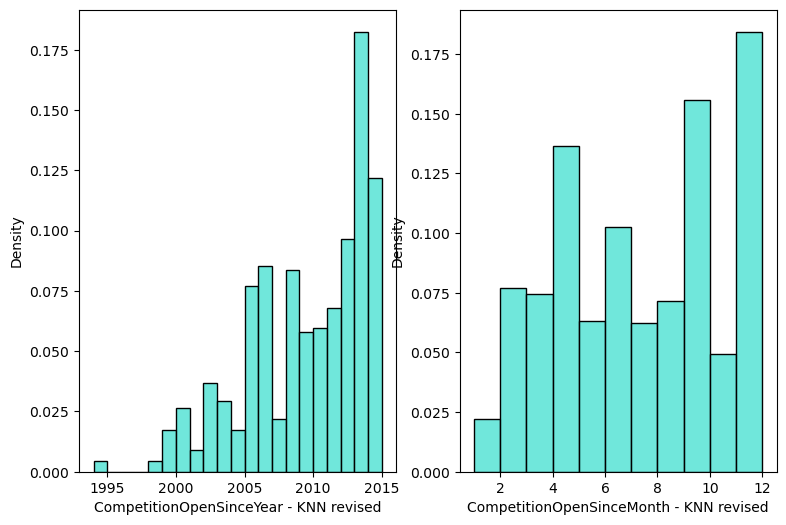

In [20]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(rm_imputed, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[0].set_xlabel('CompetitionOpenSinceYear - KNN revised')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(rm_imputed, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[1].set_xlabel('CompetitionOpenSinceMonth - KNN revised');

<hr>

**Observations:**

* `CompetitionOpenSinceYear` column
    * We observe a **bell shape curve** for inputation of `CompetitionOpenSinceYear` using the `KNN imputation` method.
    * This suggests that `KNN imputation` is most likely approriate to impute the missing values in `CompetitionOpenSinceYear`

* `CompetitionOpenSinceMonth` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.


<hr>

#### **Linear Regression Imputation**

##### Heat map

* To perform the linear regression imputation, we first have to investigate the feature columns that have the **highest correlation** with the columns that will be imputed.
* This will means that we are using `heatmap` to investigate the correlation between variables.

In [21]:
corr=rossmann.select_dtypes(include=['int','float']).corr()
corr.style.background_gradient(cmap='coolwarm')

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,AverageSales,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
Store,1.000000,-0.020639,-0.048537,0.078079,-0.035265,0.006755,0.000013,0.002910,0.012172,0.000416,-0.000074,-0.001014
CompetitionDistance,-0.020639,1.000000,-0.118109,-0.055882,-0.013439,-0.206142,-0.000014,-0.088812,-0.190187,0.009070,0.000081,-0.006431
CompetitionOpenSinceMonth,-0.048537,-0.118109,1.000000,-0.021087,-0.108020,-0.055378,0.000023,-0.023131,-0.044904,0.003392,-0.000135,0.002586
CompetitionOpenSinceYear,0.078079,-0.055882,-0.021087,1.000000,-0.185836,0.020800,-0.000064,0.008688,-0.024208,0.006310,0.000372,0.003223
Promo2,-0.035265,-0.013439,-0.108020,-0.185836,1.000000,-0.198403,0.000141,-0.085478,-0.144386,-0.016304,-0.000817,-0.007521
AverageSales,0.006755,-0.206142,-0.055378,0.020800,-0.198403,1.000000,-0.000018,0.430832,0.576898,0.031913,0.000102,0.003358
DayOfWeek,0.000013,-0.000014,0.000023,-0.000064,0.000141,-0.000018,1.000000,-0.492422,-0.368928,-0.513589,-0.392926,-0.206547
Sales,0.002910,-0.088812,-0.023131,0.008688,-0.085478,0.430832,-0.492422,1.000000,0.860537,0.752449,0.478007,0.091250
Customers,0.012172,-0.190187,-0.044904,-0.024208,-0.144386,0.576898,-0.368928,0.860537,1.000000,0.637923,0.301030,0.069432
Open,0.000416,0.009070,0.003392,0.006310,-0.016304,0.031913,-0.513589,0.752449,0.637923,1.000000,0.287123,0.085473


* It seems like the two columns with missing values, `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` have a very weak correlation with all other variables in the data set.
* In this case, we choose the best possible variable, which is the `Promo2`.

##### Iterative Imputer (Linear Imputation)

* Next, we will use the `Iterative Imputer` to impute missing values in `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` columns.

In [22]:
#Prepare Data
rossmann_reg = rossmann.select_dtypes(include=['int', 'float']).copy()
feature_columns = ['CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2']
df_to_impute = rossmann_reg[feature_columns]

# Instantiate Iterative Imputer 
imputer = IterativeImputer(estimator=LinearRegression(), random_state=1, max_iter=10)

#Fit and Transform Data 
imputed_data = imputer.fit_transform(df_to_impute)

# Impute
rossmann_reg[feature_columns] = imputed_data

#rossmann_reg.isna().sum()

In [23]:
kNN_model(rossmann_reg,['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.620, precision 0.662, recall 0.620


<hr>

* Plot histogram

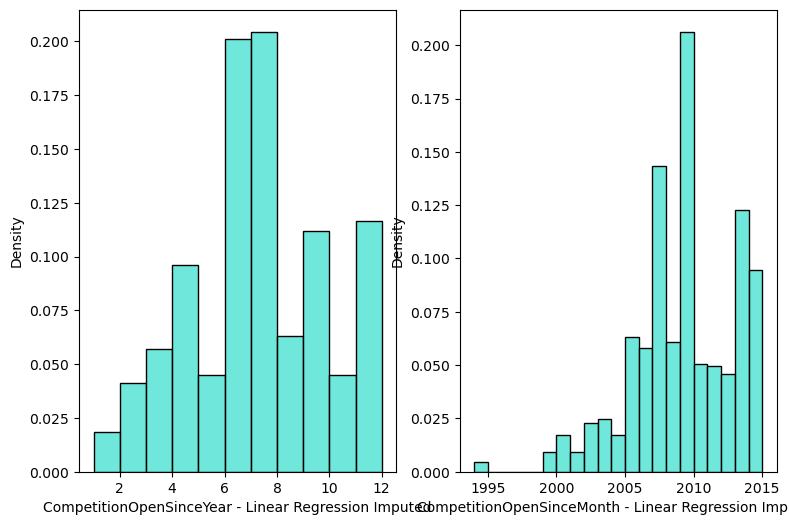

In [24]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(rossmann_reg, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[1].set_xlabel('CompetitionOpenSinceMonth - Linear Regression Imputed')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(rossmann_reg, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[0].set_xlabel('CompetitionOpenSinceYear - Linear Regression Imputed');

<hr>

**Observations:**

* `CompetitionOpenSinceYear` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.ionOpenSinceYear`

* `CompetitionOpenSinceMonth` column
    * We observe some **peaks** in the histogram.
    * This means that distribution for `CompetitionOpenSinceMonth` values is not normally distributed using the `KNN imputation` method.
    * We may use other methods to perform imputation on `CompetitionOpenSinceMonth` column.


<hr>

#### **Forest Imputation**

In [25]:
rossmann_mice = rossmann[['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales']].copy()
# Initialize Iterative Imputer with RandomForestRegressor
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, random_state=0), random_state=0)

# Fit and transform data
imputed_data = imputer.fit_transform(rossmann_mice)

# Convert imputed data back to DataFrame
imputed_df = pd.DataFrame(imputed_data, columns=rossmann_mice.columns)


In [26]:
kNN_model(imputed_df,feature_columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Sales'],target='Sales',n=1)



Testing scores: accuracy 0.649, precision 0.692, recall 0.649


<hr>

* Plot histogram

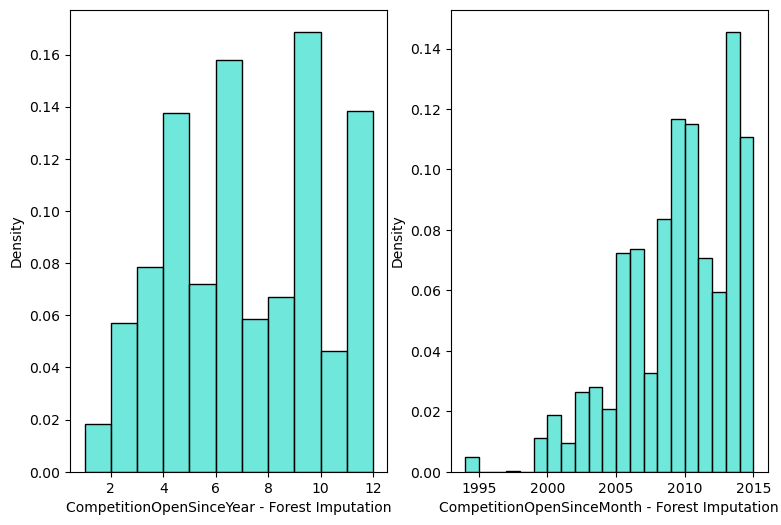

In [27]:
# Plot histograms for the imputed values
fig, axes = plt.subplots(1, 2, figsize=(9,6))

# Histogram for 'CompetitionOpenSinceMonth' linear regression imputation
sns.histplot(imputed_df, x='CompetitionOpenSinceMonth', stat="density", binwidth=1, color='turquoise', ax=axes[0])
axes[1].set_xlabel('CompetitionOpenSinceMonth - Forest Imputation')

# Histogram for 'CompetitionOpenSinceYear' linear regression imputation
sns.histplot(imputed_df, x='CompetitionOpenSinceYear', stat="density", binwidth=1, color='turquoise', ax=axes[1])
axes[0].set_xlabel('CompetitionOpenSinceYear - Forest Imputation');

<hr>

**Observations:**

* We get alomsot the same histogram plot as in the KNN imputation method


<hr>

#### **Imputation conclusion**

* As observed in the `heatmap`, we found out that the columns with missing value, specifically `CompetitionOpenSinceYear` and `CompetitionOpenSinceMonth` has a very weak correlation with other variables.
    * This suggests that these two feature variables has very minimal effect towards our target variable, the `Sales`.
* Hence, we will never get a perfect `bell shape` curve histogram for any of the imputation methods.

* The chosen imputation method is <u>KNN imputation</u>

### Time Series

In [28]:
rossmann.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 205466 entries, 2015-07-31 to 2013-01-01
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      205466 non-null  int64  
 1   StoreType                  205466 non-null  object 
 2   Assortment                 205466 non-null  object 
 3   CompetitionDistance        205466 non-null  float64
 4   CompetitionOpenSinceMonth  147592 non-null  float64
 5   CompetitionOpenSinceYear   147592 non-null  float64
 6   Promo2                     205466 non-null  int64  
 7   Promo2SinceWeek            205466 non-null  object 
 8   Promo2SinceYear            205466 non-null  object 
 9   Promo2Interval             205466 non-null  object 
 10  AverageSales               205466 non-null  float64
 11  DayOfWeek                  205466 non-null  int64  
 12  Sales                      205466 non-null  int64  
 13  Customers    

In [32]:
rossmann.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Promo2Interval,AverageSales,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Promo2IntervalCat
Date,,,,,,,,,,,,,,,,,,,
2015-07-31,4,c,c,620.0,9.0,2009.0,0,0,0,NA,8021.77,5,13995,1498,1,1,0,1,0
2015-07-31,7,a,c,24000.0,4.0,2013.0,0,0,0,NA,7356.90,5,15344,1414,1,1,0,1,0
2015-07-31,24,a,c,4590.0,3.0,2000.0,1,40.0,2011.0,"Jan,Apr,Jul,Oct",7763.77,5,14190,1082,1,1,0,1,1
2015-07-31,25,c,a,430.0,4.0,2003.0,0,0,0,NA,8892.31,5,14180,1586,1,1,0,1,0
2015-07-31,27,a,a,60.0,1.0,2005.0,1,5.0,2011.0,"Jan,Apr,Jul,Oct",7838.44,5,13213,1263,1,1,0,1,1


Now, we can start data analysis.

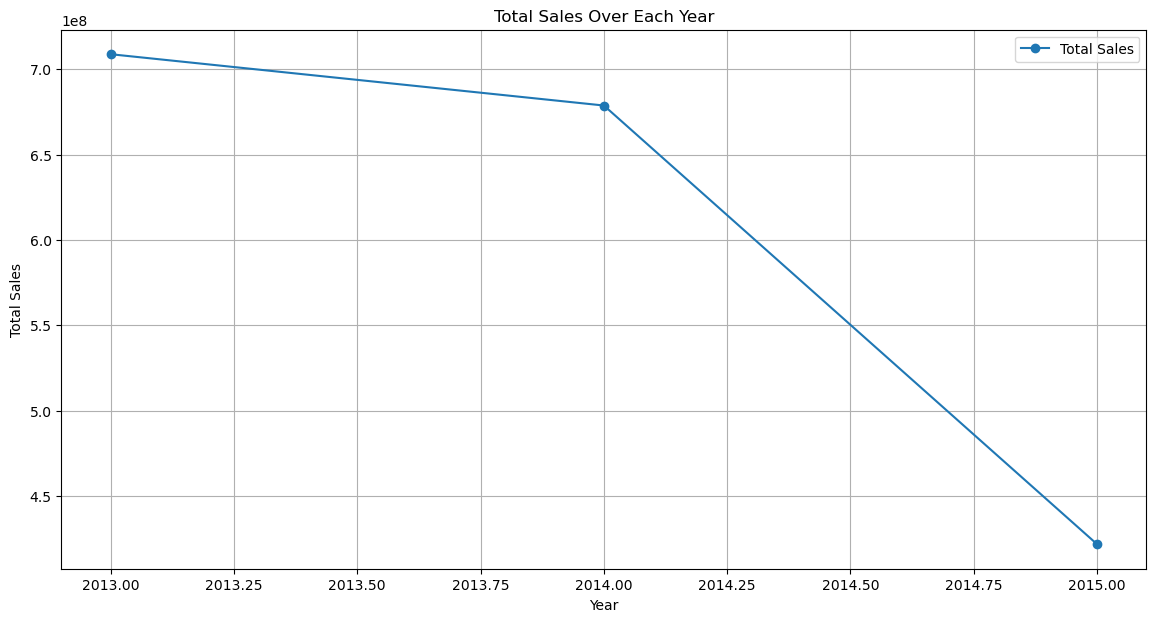

In [59]:
sales_year = rossmann['Sales'].resample('Y').sum()

# Plot the total sales over each year
plt.figure(figsize=(14, 7))
plt.plot(yearly_sales.index.year, sales_year, marker = 'o',label='Total Sales')
plt.title('Total Sales Over Each Year')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.legend()
plt.grid(True)
plt.show()


From the above plot, we see that there is a clear decline in sales in the year 2014
So let's see what the total sales pattern is like in 2014:

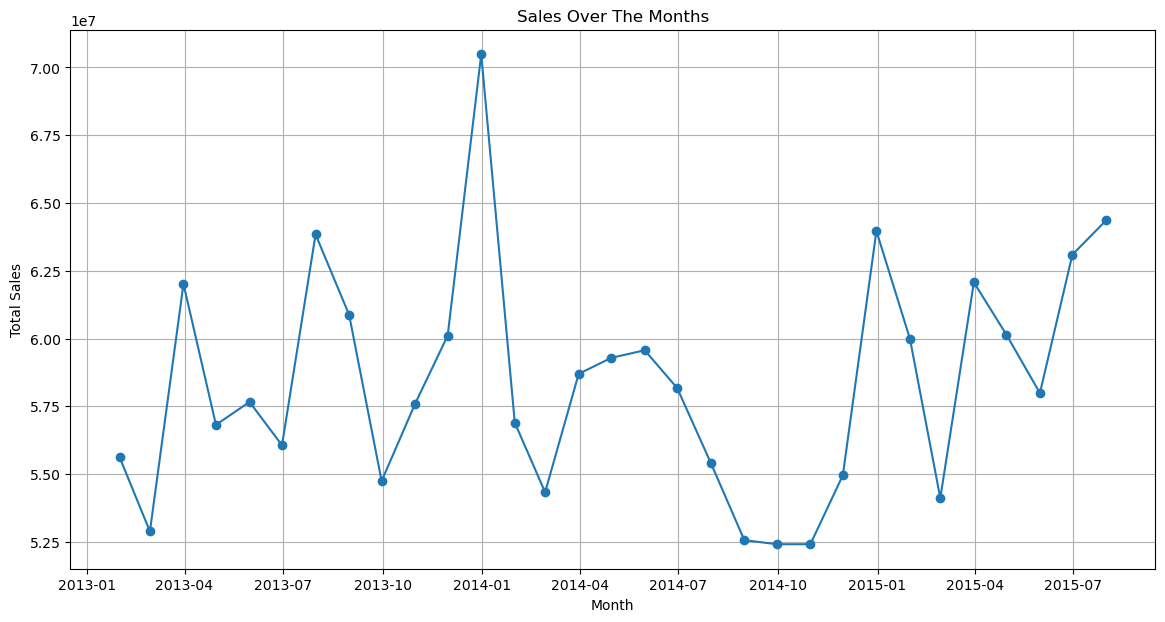

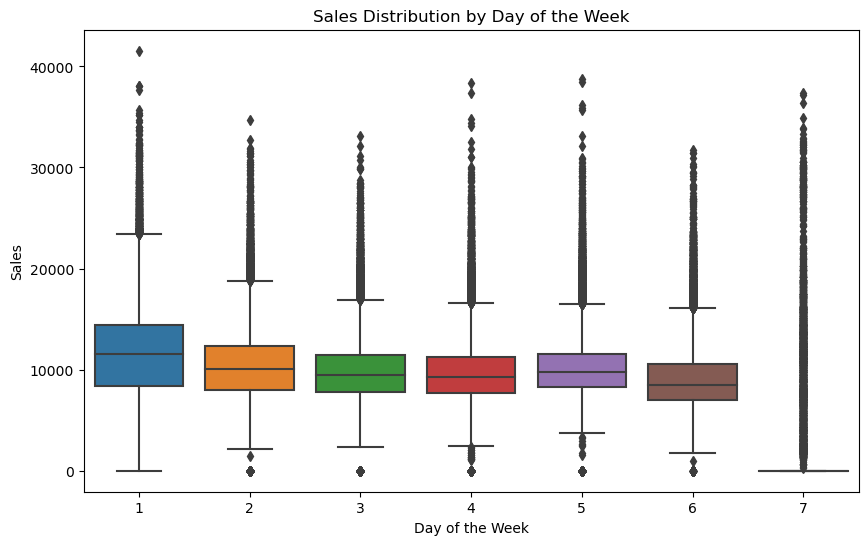

In [60]:
sales_monthly = rossmann['Sales'].resample('M').sum()

plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index, sales_monthly, marker='o', label='Monthly Sales')
plt.title('Sales Over The Months')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Sales', data=rossmann)
plt.title('Sales Distribution by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Sales')
plt.show()


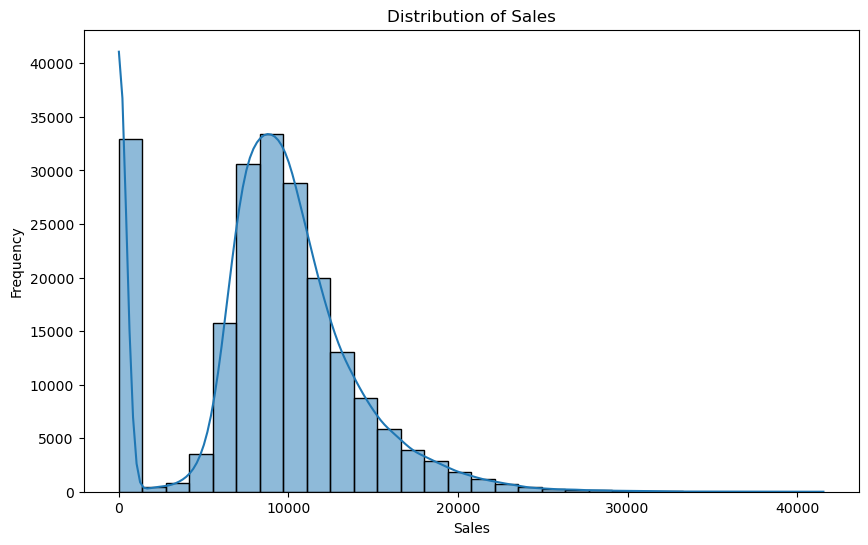

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(rossmann['Sales'], bins=30, kde=True)
plt.title('Distribution of Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.show()

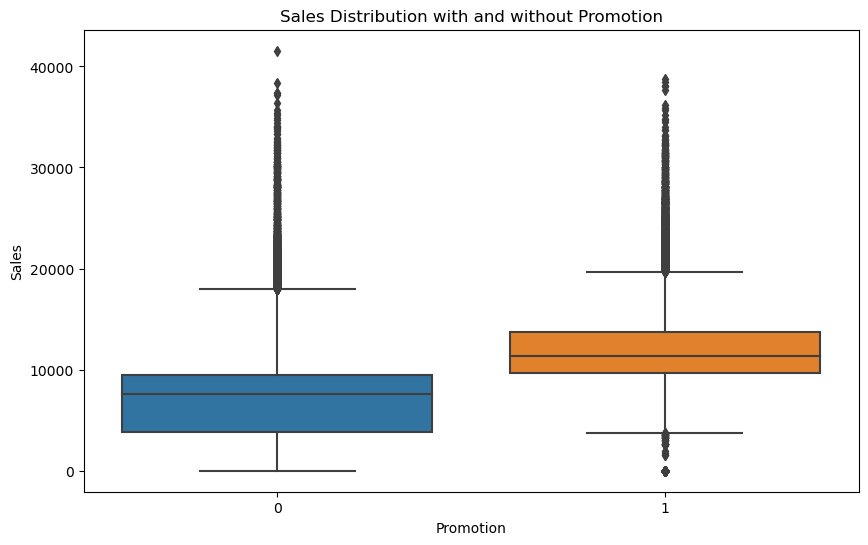

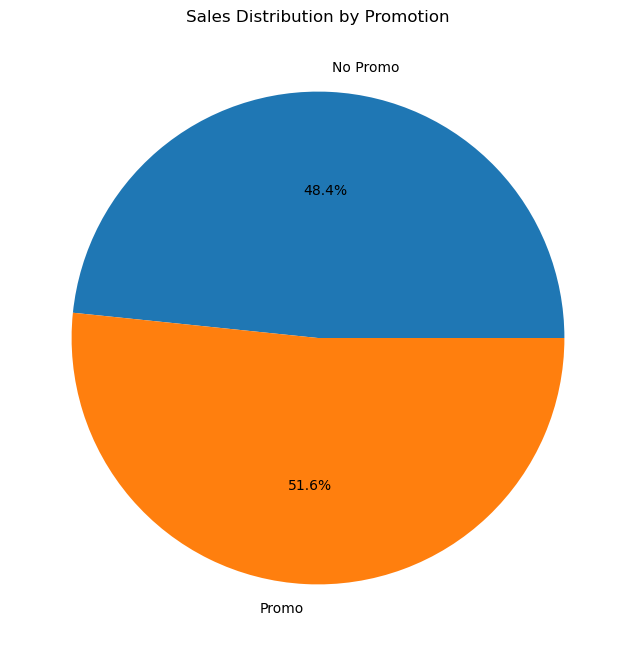

In [62]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promo', y='Sales', data=rossmann)
plt.title('Sales Distribution with and without Promotion')
plt.xlabel('Promotion')
plt.ylabel('Sales')
plt.show()

promo_sales = rossmann.groupby('Promo')['Sales'].sum()
plt.figure(figsize=(8, 8))
plt.pie(promo_sales, labels=['No Promo', 'Promo'],autopct='%1.1f%%')
plt.title('Sales Distribution by Promotion')
plt.show()


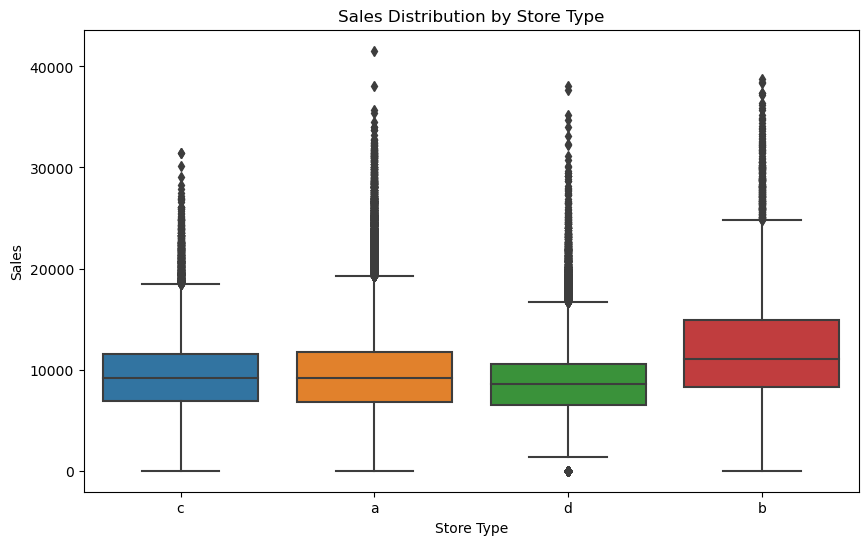

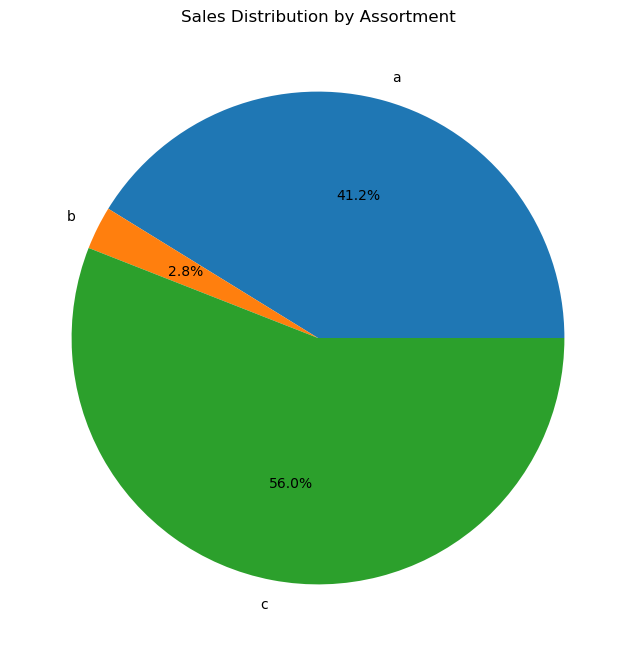

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='StoreType', y='Sales', data=rossmann)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

assortment_sales = rossmann.groupby('Assortment')['Sales'].sum()
plt.figure(figsize=(8, 8))
plt.pie(assortment_sales, labels=assortment_sales.index, autopct='%1.1f%%')
plt.title('Sales Distribution by Assortment')
plt.show()
